# Predicting The Outcome of Kickstarter Projects


# Abstract

(Insert abstract here)

# What is Kickstarter

To put it in their own words “Kickstarter helps artists, musicians, filmmakers, designers, and other creators find the resources and support they need to make their ideas a reality. To date, tens of thousands of creative projects — big and small — have come to life with the support of the Kickstarter community.”

It is a platform that allows creators to transform ideas through the use of crowdfunding from backers in order to create tangible products. Creators are the people that set deadlines with funding goals that need to be met in order for them to create their projects, as well as stretch goals that may be created if that goal is surpassed. Projects can also have their deadlines extended and funding goals adjusted after the fact

# About the Data

In this dataset lies a collection of 378,661 projects from April 2009 to January 2018 that contain a wide variety of project types and goals. The columns provided in the dataset are the
1. Project ID
2. Project name
3. Category
4. Main category
5. Currency type (USD,  EUR, GBP, etc.)
6. Deadline
7. Goal
8. Launch date
9. Pledged amount
10. State of the project (Successful, failed, cancelled, live, suspended)
11. Number of backers
12. Country of origin
13. USD pledged
14. USD pledged real
15. USD goal real

# Research Question

Now, the goal of this project is to determine what factors ultimately determine the success (or failure) of a kickstarter project, given the tools at our disposal.

In [27]:
# Import basic statements
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import HTML

# Import visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly as py
import plotly.graph_objs as go
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

# Machine learning packages
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# Import data and sort by deadline date
kickstart_data = pd.read_csv("ks-projects-201801.csv")

# Drop all empty rows
kickstart_data.dropna()

# Preview the data, ordered by deadline
kickstart_data.sort_values('deadline').head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
138572,1703704063,drawing for dollars,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,35.0,successful,3,US,35.0,35.0,20.0
213711,2089078683,New York Makes a Book!!,Journalism,Journalism,USD,2009-05-16,3000.0,2009-04-28 13:55:41,3329.0,successful,110,US,3329.0,3329.0,3000.0
342226,813230527,Sponsor Dereck Blackburn (Lostwars) Artist in ...,Rock,Music,USD,2009-05-16,300.0,2009-04-29 05:26:32,15.0,failed,2,US,15.0,15.0,300.0
28960,1147015301,"""All We Had"" Gets Into Cannes -- $10 or More G...",Documentary,Film & Video,USD,2009-05-20,300.0,2009-04-30 22:10:30,40.0,failed,4,US,40.0,40.0,300.0
196244,199916122,Mr. Squiggles,Illustration,Art,USD,2009-05-22,30.0,2009-05-12 23:39:58,0.0,failed,0,US,0.0,0.0,30.0


# Data Cleaning

In [3]:
# Check the size of our dataset
kickstart_data.shape

(378661, 15)

In [4]:
# Print out column names and # of unique values in each categorical variable
kickstart_data.select_dtypes(include=['object']).nunique()

name             375764
category            159
main_category        15
currency             14
deadline           3164
launched         378089
state                 6
country              23
dtype: int64

In [5]:
# Convert 'launched' and 'deadline' columns into dates
kickstart_data['launched'] = kickstart_data['launched'].astype('datetime64[ns]')
kickstart_data['deadline'] = pd.to_datetime(kickstart_data['deadline'])
kickstart_data['launched'] = pd.DatetimeIndex(kickstart_data.launched).normalize()

# Project duration is more useful and less data
# than the launch date and deadline
kickstart_data['duration'] = kickstart_data['deadline'] - kickstart_data['launched']
kickstart_data['duration'] = (kickstart_data['duration'] / np.timedelta64(1, 'D')).astype(int)

# Drop variables that have no impact on the outcome, and
# variables that have over 15 unique values
kickstart_data.drop(['ID', 'name', 'category', 'launched', 'deadline', 
                     'currency', 'goal', 'pledged', 'usd pledged'], 1, inplace=True)

# Rename usd_pledged_real and usd_goal_real to 
# pledged and goal
kickstart_data = kickstart_data.rename(index=str, columns = {'usd_pledged_real': 'pledged', 
                                                             'usd_goal_real': 'goal', 
                                                             'main_category': 'category'})

# Let's create a new variable, pledged% to show how much
# of the goal was met
kickstart_data['pledge_percent'] = kickstart_data['pledged'] / kickstart_data['goal'] * 100

# Exploratory Data Analysis

In [6]:
# Summary of the dataset
kickstart_data.describe()

,backers,pledged,goal,duration,pledge_percent
count,378661.000000,3.786610e+05,3.786610e+05,378661.000000,3.786610e+05
mean,105.617476,9.058924e+03,4.545440e+04,34.481095,3.236121e+02
std,907.185035,9.097334e+04,1.152950e+06,65.909173,2.669054e+04
min,0.000000,0.000000e+00,1.000000e-02,1.000000,0.000000e+00
25%,2.000000,3.100000e+01,2.000000e+03,30.000000,4.533333e-01
50%,12.000000,6.243300e+02,5.500000e+03,30.000000,1.346400e+01
75%,56.000000,4.050000e+03,1.550000e+04,37.000000,1.065400e+02
max,219382.000000,2.033899e+07,1.663614e+08,16739.000000,1.042779e+07


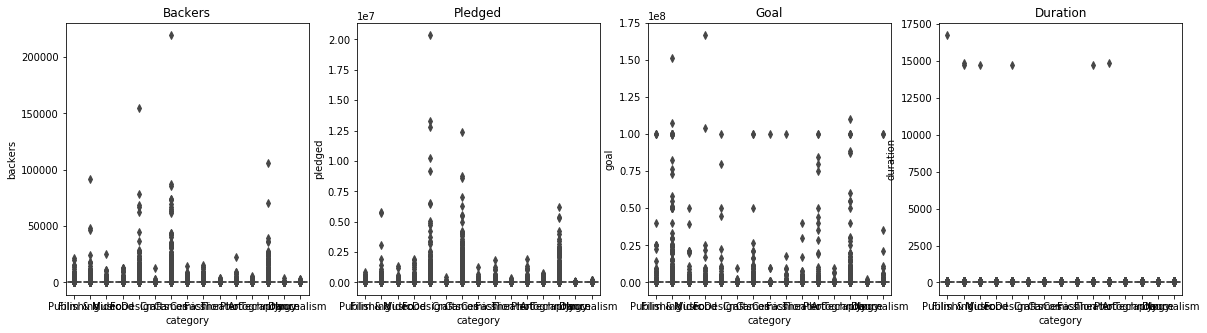

In [7]:
# Plot all of variables, and try to identify outliers
plt.rcParams['figure.figsize'] = [20,5]

plt.subplot(1,4,1)
plt.title('Backers')
ax = sns.boxplot(x="category", y="backers", data=kickstart_data)

plt.subplot(1,4,2)
plt.title('Pledged')
ax = sns.boxplot(x="category", y="pledged", data=kickstart_data)

plt.subplot(1,4,3)
plt.title('Goal')
ax = sns.boxplot(x="category", y="goal", data=kickstart_data)

plt.subplot(1,4,4)
plt.title('Duration')
ax = sns.boxplot(x="category", y="duration", data=kickstart_data)

Well, one of the great things about Kickstarter is that there are technically no limits to the scale of the projects that can emerge from the platform. Feel free to look at Star Citizen if you were wondering what project generated over 2 million dollars in pledges.

<a href="https://www.kickstarter.com/projects/cig/star-citizen">Star Citizen</a>



So, our problem is that there are quite a lot of ambitious projects that drew in a substantial amount of backers with goals far above 75% of other projects, leading to the messy visualization above. The duration variable looks like there are few enough genuine outliers for us to examine. As for the rest, it seems like we'll need to transform them before proceeding because there are simply too many outliers for us to ignore.

In [8]:
# Order by duration
kickstart_data.sort_values('duration', ascending = False).head(8)

,category,state,backers,country,pledged,goal,duration,pledge_percent
319002,Publishing,suspended,0,CH,0.0,1905.97,16739,0.0
2842,Film & Video,canceled,0,US,0.0,5000.00,14867,0.0
48147,Art,canceled,0,US,0.0,15000.00,14835,0.0
94579,Theater,canceled,0,US,0.0,4000.00,14761,0.0
75397,Film & Video,canceled,0,US,0.0,700.00,14750,0.0
247913,Music,canceled,0,US,0.0,10000.00,14733,0.0
273779,Design,canceled,0,US,0.0,500.00,14709,0.0
200310,Film & Video,failed,0,US,0.0,250000.00,92,0.0


As we had expected earlier, it seems as though out of 370,000+ projects, only 7 of them seem to have a suspiciously long duration. Since this is an extremely small subset of rows from our dataframe, we can safely remove them from the dataset before proceeding.

In [9]:
# Drop our 7 outliers from the dataset based on duration
kickstart_data.drop(kickstart_data.sort_values('duration', ascending = False).head(7).index, axis=0, inplace = True)

In [10]:
# Applying log transformations to 'backers', 'pledged', and 'goal' columns
kickstart_data['backers'] = np.log(kickstart_data['backers'])
kickstart_data['pledged'] = np.log(kickstart_data['pledged'])
kickstart_data['goal'] = np.log(kickstart_data['goal'])

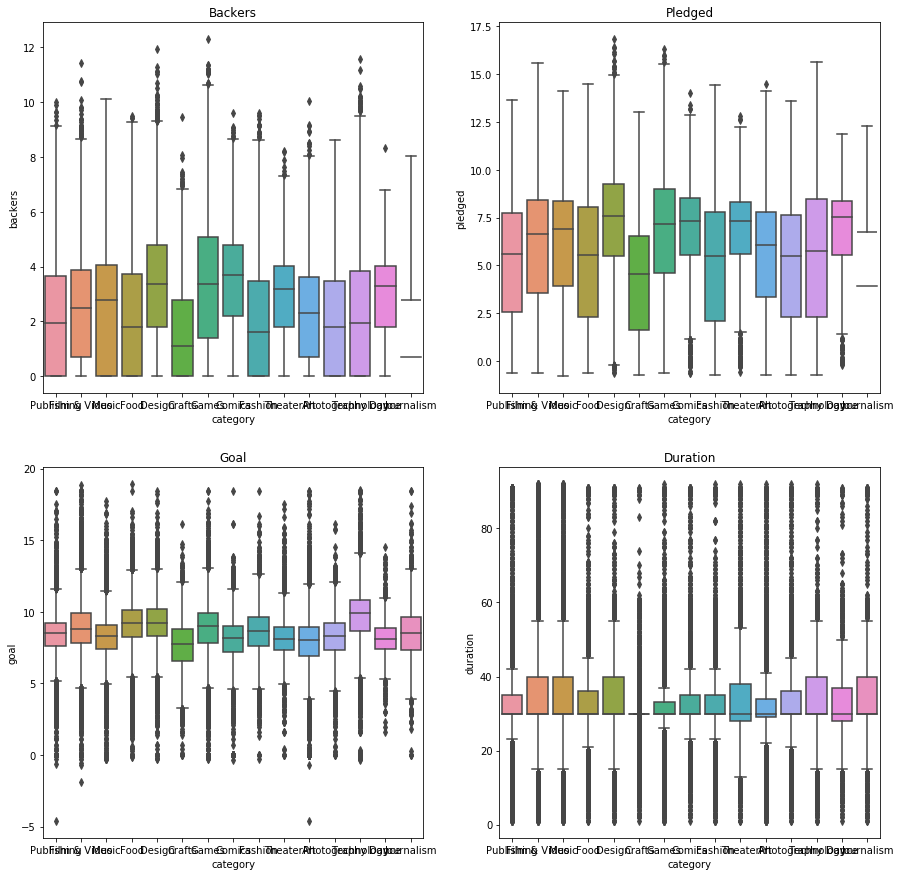

In [11]:
# Plot all of variables, and try to identify outliers
plt.rcParams['figure.figsize'] = [15,15]

plt.subplot(2,2,1)
plt.title('Backers')
ax = sns.boxplot(x="category", y="backers", data=kickstart_data)

plt.subplot(2,2,2)
plt.title('Pledged')
ax = sns.boxplot(x="category", y="pledged", data=kickstart_data)

plt.subplot(2,2,3)
plt.title('Goal')
ax = sns.boxplot(x="category", y="goal", data=kickstart_data)

plt.subplot(2,2,4)
plt.title('Duration')
ax = sns.boxplot(x="category", y="duration", data=kickstart_data)

So after removing our outliers from the 'duration' column, and applying a log transformation to the 'backers', 'pledged', and 'goal' columns, we can see a somewhat normal distribution.

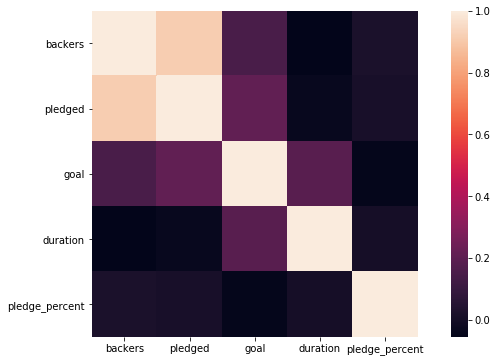

In [21]:
# Creates a correlation matrix among the predictor variables
correlation_martix = kickstart_data.corr()
sns.heatmap(correlation_martix, vmax = 1, square = True)
plt.show()

There appears to be a very high degree of similarity between the number of backers, and total monetary amount contributed. This makes sense if we assume that each backer donates roughly the same amount, leading to two columns that have quite a lot in common. We can try removing one or the other later if we need to determine which of these factors is more important than the other. For now, we'll use both predictors in our model.

In [22]:
categorical = pd.get_dummies(kickstart_data)

In [25]:
categorical.head()

,backers,pledged,goal,duration,pledge_percent,category_Art,category_Comics,category_Crafts,category_Dance,category_Design,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,-inf,-inf,7.335601,59,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.708050,7.791936,10.308953,60,8.070000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1.098612,5.393628,10.714418,45,0.488889,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.000000,0.000000,8.517193,30,0.020000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2.639057,7.156956,9.878170,56,6.579487,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
# Pass in values for our pie chart
trace = go.Pie(labels=kickstart_data['category'].unique(), values = kickstart_data['category'].value_counts())

# Create the layout
layout = go.Layout(
    title = 'Kickstarter Projects by Category',
    height = 600,
    width = 800,
    autosize = False
)

# Construct the chart
fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig, filename ='cufflinks/simple')

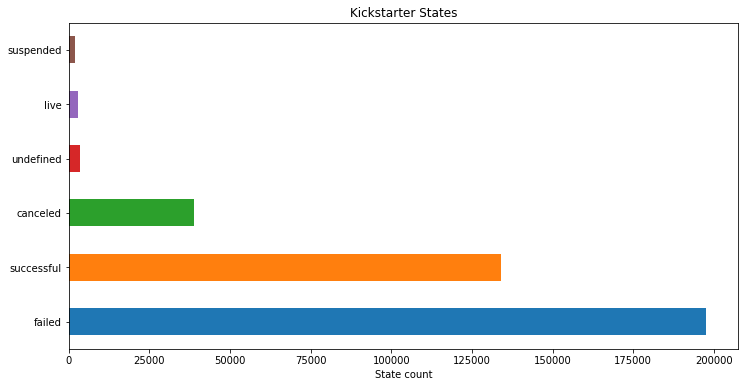

In [13]:
# Plot kickstarter states
plt.rcParams['figure.figsize'] = [12,6]
plt.title('Kickstarter States')
plt.xlabel('State count')
kickstart_data['state'].value_counts().plot(kind='barh')

In [31]:
# Remove 'suspended', 'live', and 'undefined' states from the dataset
kickstart_data = kickstart_data[kickstart_data.state != ('suspended', 'live', 'undefined')]

# Consolidate 'canceled' and 'failed' into one category
success_rate = np.where(kickstart_data.state == 'successful', 1, 0)

# Remove the 'state' column from our dataset
# since it's not a predictor, it's the outcome
kickstart_data.drop(['state'], axis = 1)

,category,backers,country,pledged,goal,duration,pledge_percent
0,Publishing,-inf,GB,-inf,7.335601,59,0.000000
1,Film & Video,2.708050,US,7.791936,10.308953,60,8.070000
2,Film & Video,1.098612,US,5.393628,10.714418,45,0.488889
3,Music,0.000000,US,0.000000,8.517193,30,0.020000
4,Film & Video,2.639057,US,7.156956,9.878170,56,6.579487
5,Food,5.411646,US,10.866185,10.819778,35,104.750000
6,Food,2.772589,US,7.094235,6.907755,20,120.500000
7,Food,3.688879,US,6.115892,10.126631,45,1.812000
8,Design,4.060443,US,9.015906,11.736069,35,6.586400
9,Film & Video,3.761200,US,8.738827,11.082143,30,9.600877


(-1.1154681955525665,
 1.1143348565040996,
 -1.1132377615610414,
 1.117099503783597)

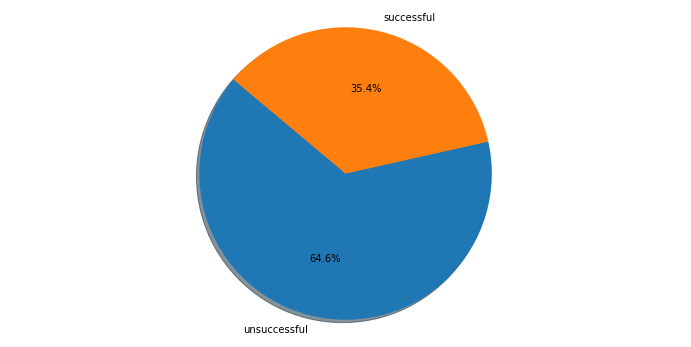

In [15]:
plt.pie(np.bincount(success_rate), labels=['unsuccessful', 'successful'],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

# Model 1: Linear Regression

In [28]:
X_train, X_test, y_train, y_test = train_test_split(kickstart_data, success_rate, test_size=0.3)

In [29]:
# Constructing our logistic regression model
lr = LogisticRegression(C = 1e9)

# Checking the accuracy of our model using cross validation
cross_val_score(lr, X_train, y_train, cv=5)

ValueError: could not convert string to float: 'US'

In [ ]:
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

confusion_matrix(y_test, lr_pred)

In [16]:
# sns.distplot(kickstart_data['pledge_percent'], kde = False, rug = True)

In [17]:
# sns.jointplot(kickstart_data['pledged'], kickstart_data['goal'], kickstart_data)

In [18]:
#from sklearn import ensemble
#from sklearn.model_selection import cross_val_score

#rfc = ensemble.RandomForestClassifier()
#X = data.drop('state', 1)
#Y = data['state']
#X = pd.get_dummies(X)
#X = X.dropna(axis=1)

#cross_val_score(rfc, X, Y, cv=10)

# Source:
Kickstarter Data Page - 
https://www.kaggle.com/kemical/kickstarter-projects/data